In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, pickle
import sklearn
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import auc
from scipy import interp

In [28]:
def evaluate_performance(observed, predicted):
    accuracy = sklearn.metrics.accuracy_score(observed, predicted)
    precision = sklearn.metrics.precision_score(observed, predicted)
    recall = sklearn.metrics.recall_score(observed, predicted)
    f1 = sklearn.metrics.f1_score(observed, predicted)
    mcc = sklearn.metrics.matthews_corrcoef(observed, predicted, sample_weight=None)
    auc = sklearn.metrics.roc_auc_score(observed, predicted)
    return({'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1':f1, 'MCC':mcc, 'AUC':auc})

In [36]:
sort_key = lambda x: int(x.split('-')[0][6:])
chunks = np.concatenate([np.load('streamlit_app/embedding_chunks/'+chunk) for chunk in 
                         sorted(os.listdir('streamlit_app/embedding_chunks'), key=sort_key)], axis = 0)

In [37]:
sorted(os.listdir('streamlit_app/embedding_chunks'), key=sort_key)

['chunk_1-41.npy',
 'chunk_42-83.npy',
 'chunk_84-124.npy',
 'chunk_125-166.npy',
 'chunk_167-207.npy',
 'chunk_208-249.npy',
 'chunk_250-291.npy',
 'chunk_292-332.npy',
 'chunk_333-374.npy',
 'chunk_375-415.npy',
 'chunk_416-457.npy',
 'chunk_458-499.npy',
 'chunk_500-540.npy',
 'chunk_541-582.npy',
 'chunk_583-623.npy',
 'chunk_624-665.npy',
 'chunk_666-706.npy',
 'chunk_707-748.npy',
 'chunk_749-790.npy',
 'chunk_791-831.npy',
 'chunk_832-873.npy',
 'chunk_874-914.npy',
 'chunk_915-956.npy',
 'chunk_957-998.npy',
 'chunk_999-1039.npy',
 'chunk_1040-1081.npy',
 'chunk_1082-1122.npy',
 'chunk_1123-1164.npy',
 'chunk_1165-1205.npy',
 'chunk_1206-1247.npy',
 'chunk_1248-1289.npy',
 'chunk_1290-1330.npy',
 'chunk_1331-1372.npy',
 'chunk_1373-1413.npy',
 'chunk_1414-1455.npy',
 'chunk_1456-1497.npy',
 'chunk_1498-1538.npy',
 'chunk_1539-1580.npy',
 'chunk_1581-1621.npy',
 'chunk_1622-1663.npy',
 'chunk_1664-1704.npy',
 'chunk_1705-1746.npy',
 'chunk_1747-1788.npy',
 'chunk_1789-1829.npy',

In [38]:
np.where(chunks[:, 0] == 8298)

(array([3904, 4467, 5491]),)

In [43]:
chunks[3900:3905, 0]

array([8181.,    0.,    0.,    0., 8298.])

In [46]:
np.where(exp['labels'].astype(int) == 8298)

(array([3904, 4467, 5491]),)

In [47]:
np.where(labs['labels'].astype(int) == 8298)

NameError: name 'labs' is not defined

In [8]:
exp = pd.read_csv('streamlit_app/labeled_examples.csv', encoding="ISO-8859-1", dtype='object')

In [20]:
chunks.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [32]:
X_train, X_test, y_train, y_test = train_test_split(chunks[:, 1:], (chunks[:, 0] > 0).astype(int), test_size=0.2, random_state=40)

In [33]:
imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                              LogisticRegression(C=.3, penalty='l2', solver='newton-cg', 
                                                 multi_class='multinomial', n_jobs=-1, random_state=13))
cv_scores = cross_val_score(imba_pipeline, X_train, y_train, scoring='roc_auc', cv=5)

In [34]:
np.mean(cv_scores)

0.6693364692690075

In [35]:
sm = SMOTE(random_state=42)
X_train_upsample, y_train_upsample = sm.fit_resample(X_train, y_train)
logreg = LogisticRegression(C=.3, penalty='l2', solver='newton-cg',multi_class='multinomial', n_jobs=-1, random_state=13)
logreg.fit(X_train_upsample, y_train_upsample)
y_pred = logreg.predict(X_test)
evaluate_performance(y_test, y_pred)

KeyboardInterrupt: 

In [40]:
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, preds)
roc_auc = sklearn.metrics.auc(fpr, tpr)

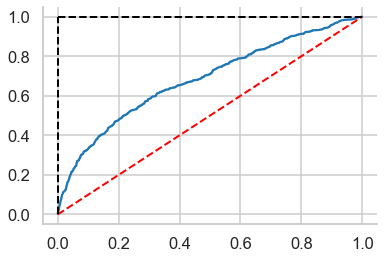

In [46]:
sns.set_style('whitegrid')
sns.set_context('talk')
sns.lineplot(x=fpr, y=tpr)
sns.despine()
plt.plot([0, 1], [0, 1], linewidth=2, linestyle='--', color='red')
plt.plot([0, 0], [0, 1], linewidth=2, linestyle='--', color='black')
plt.plot([0, 1], [1, 1], linewidth=2, linestyle='--', color='black')

In [48]:
#Train the model on all available data for pickling
X = chunks[:, 1:]
y = chunks[:, 0] > 0
X_train_upsample, y_train_upsample = sm.fit_resample(X, y)
logreg_full = LogisticRegression(C=.3, penalty='l2', solver='newton-cg',multi_class='multinomial', n_jobs=-1, random_state=13)
logreg_full.fit(X_train_upsample, y_train_upsample)

LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=13, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
filename = 'trained_model.sav'
pickle.dump(logreg_full, open(filename, 'wb'))